<h1 align = 'center'>DS200 - Lec22: Support Vector Machine</h1>

## Introduction:

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space (N being the number of features) that distinctly classifies the data points.

The data science problem we are trying to solve in this lecture is to classify recipes as cupcakes or muffins by using SVM algorithm. Eventually we want to generate an application so that when given a new recipe, we can determine if it's a cupcake or a muffin.

### __Step 1:__ Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### __Step 2:__ Import Data

Read in muffin and cupcake ingredient data from the given URL. Name the DataFrame as recipes.

In [2]:
url = 'https://raw.githubusercontent.com/BlueJayADAL/DS200/master/datasets/svm_demo.csv'

In [3]:
recipes = pd.read_csv(url)



# Display the top 5 records
recipes.head()

,Type,Flour,Milk,Sugar,Butter,Egg,Baking Powder,Vanilla,Salt
0,Muffin,55,28,3,7,5,2,0,0
1,Muffin,47,24,12,6,9,1,0,0
2,Muffin,47,23,18,6,4,1,0,0
3,Muffin,45,11,17,17,8,1,0,0
4,Muffin,50,25,12,6,5,2,1,0


### __Step 3:__ EDA

Check out the count of each label.

<AxesSubplot:xlabel='Type', ylabel='count'>

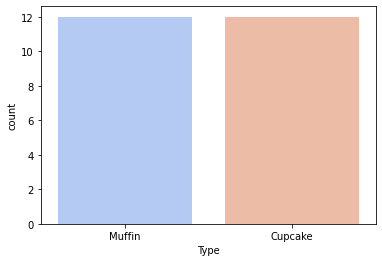

In [4]:
sns.countplot(data=recipes, x='Type', palette='coolwarm')



Recreate the following plot.

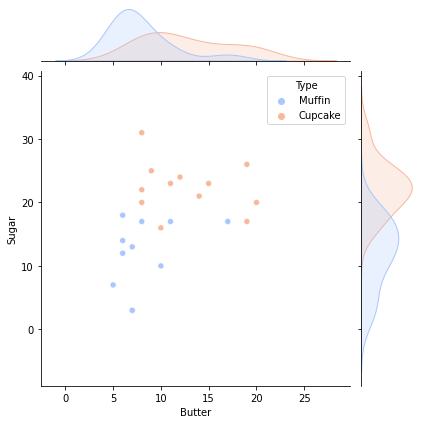

In [5]:
# Plot two ingredients
sns.jointplot(data=recipes, 
              x='Butter', 
              y='Sugar', 
              hue='Type', 
              palette='coolwarm')




Recreate the following plot.

In [6]:
recipes.columns


Index(['Type', 'Flour', 'Milk', 'Sugar', 'Butter', 'Egg', 'Baking Powder',
       'Vanilla', 'Salt'],
      dtype='object')

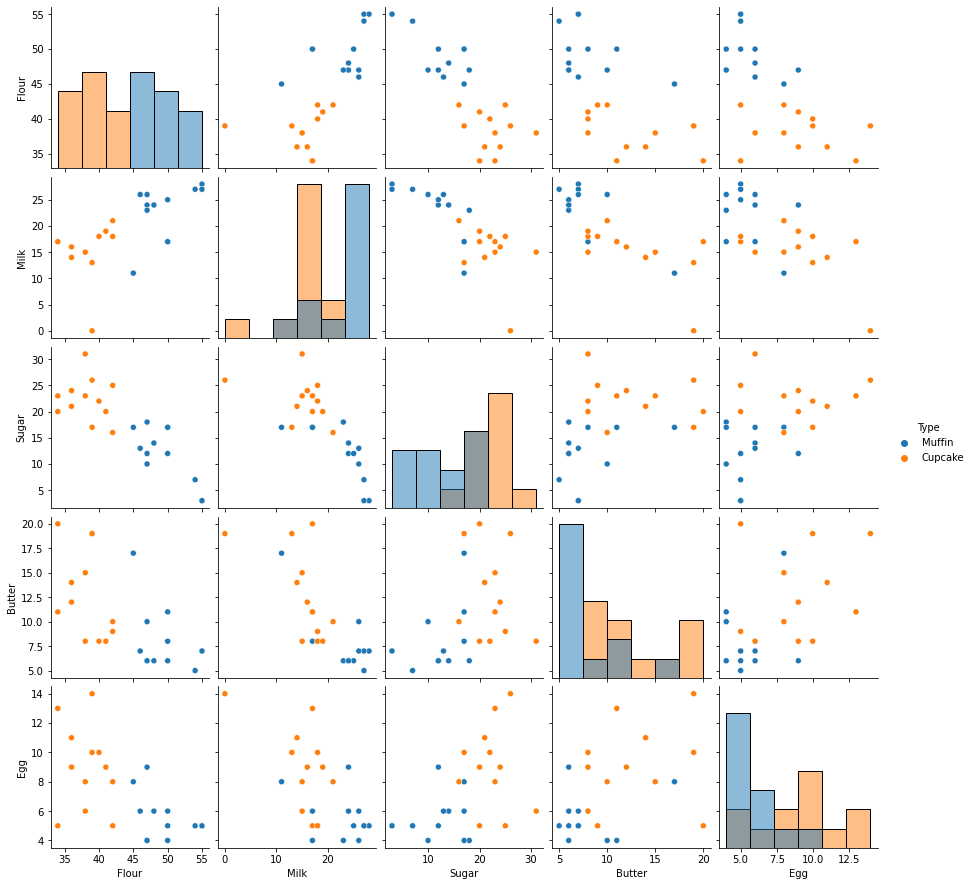

In [7]:
sns.pairplot(data=recipes.drop(['Baking Powder', 'Vanilla', 'Salt'], axis=1), hue='Type', diag_kind='hist')



### Step 4: Data Preparation
#### Convert type into numbers. 'Muffin' -- 0, 'Cupcake' -- 1

In [8]:
def convert_type (type_str): 
    if type_str == 'Cupcake':
        return 1
    else:
        return 0
    


    

Create a new column to the DataFrame called `Label`

In [9]:
recipes['Label'] = recipes['Type'].apply(convert_type)



In [10]:
recipes.head()

,Type,Flour,Milk,Sugar,Butter,Egg,Baking Powder,Vanilla,Salt,Label
0,Muffin,55,28,3,7,5,2,0,0,0
1,Muffin,47,24,12,6,9,1,0,0,0
2,Muffin,47,23,18,6,4,1,0,0,0
3,Muffin,45,11,17,17,8,1,0,0,0
4,Muffin,50,25,12,6,5,2,1,0,0


Get X feature matrix and y label vector. Only use Flour and Sugar as two features.

In [11]:
X = recipes[['Flour', 'Sugar']]


y = recipes['Label']



#### Standardize the features

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
ss = StandardScaler()
X = ss.fit_transform(X)



Split X, y into training and testing parts. Testing size set to 20%

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### __Step 5:__ Fit the Model

In [16]:
from sklearn.svm import SVC

In [17]:
# Fit the SVM model
model = SVC(kernel='linear', random_state=101)

model.fit(X_train, y_train)

SVC(kernel='linear', random_state=101)

### __Step 6:__ Prediction and Evaluation

In [18]:
predictions = model.predict(X_test)



In [19]:
from sklearn.metrics import classification_report, confusion_matrix



In [20]:
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[2 0]
 [0 3]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



### Step 7: Create a function to guess when a recipe is a muffin or a cupcake

In [21]:
model.predict(np.array([50,20]).reshape(1, -1))

array([0], dtype=int64)

In [22]:
def muffin_or_cupcake(flour, sugar):
    scaled = ss.transform(np.array([flour, sugar]).reshape(1, -1))
    if model.predict(scaled) == 0:
        print('Muffin it is!')
    else:
        print('Cupcake it is!')





In [23]:
# Predict if 50 parts flour and 20 parts sugar
muffin_or_cupcake(50, 20)

Muffin it is!


In [24]:
# Predict if 40 parts flour and 20 parts sugar
muffin_or_cupcake(40, 20)

Cupcake it is!


### Step 8: Re-evaluate the Model
#### Gridsearch
Finding the right parameters (like what C or gamma values to use) is a tricky task! But luckily, we can be a little lazy and just try a bunch of combinations and see what works best! This idea of creating a 'grid' of parameters and just trying out all the possible combinations is called a Gridsearch, this method is common enough that Scikit-learn has this functionality built in with GridSearchCV! The CV stands for cross-validation which is the

GridSearchCV takes a dictionary that describes the parameters that should be tried and a model to train. The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

In [25]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [26]:
from sklearn.model_selection import GridSearchCV



One of the great things about GridSearchCV is that it is a meta-estimator. It takes an estimator like SVC, and creates a new estimator, that behaves exactly the same - in this case, like a classifier. You should add `refit=True` and choose `verbose` to whatever number you want, higher the number, the more verbose (verbose just means the text output describing the process).

In [27]:
grid = GridSearchCV(estimator=SVC(random_state=101),
                    param_grid=param_grid,
                    refit=True,
                    verbose=3)



What fit does is a bit more involved than usual. First, it runs the same loop with cross-validation, to find the best parameter combination. Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation), to built a single new model using the best parameter setting.

In [28]:
# May take awhile!
grid.fit(X_train, y_train)



Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(random_state=101),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [29]:
# Find the best parameters combination
grid.best_params_


{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [30]:
# Get the best estimator object
best_model = grid.best_estimator_



In [31]:
grid_predictions = grid.predict(X_test)



In [32]:
print(confusion_matrix(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))

[[2 0]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



## Great job!